In [2]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import ccf_streamlines.projection as ccfproj
from datasets import load_from_disk
import yaml

from utils import reflect_points_to_left


In [2]:
predictions_path = "/grid/zador/home/benjami/brain-annotation/outputs/2024-11-04/16-15-17/test_brain_predictions.npy" # 64 cells
ccf_files_path = "/grid/zador/data_norepl/Ari/transcriptomics/CCF_files"

predictions_path = "/grid/zador/home/benjami/brain-annotation/outputs/single_cell_preds_32/validation_brain_predictions.npy" # 128 cells

In [3]:
pred_dict = np.load(predictions_path, allow_pickle=True).item()

In [62]:
[len(pred_dict['locations']), len(pred_dict['predictions'])], pred_dict.keys()

([3510, 3510],
 dict_keys(['locations', 'labels', 'predictions', 'indices', 'label_names']))

In [63]:
acc = (np.array(pred_dict['labels']) == np.array(pred_dict["predictions"])).sum() / len(pred_dict['labels'])
print("Accuracy", acc)

Accuracy 0.7333333333333333


In [3]:
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=    os.path.join(ccf_files_path,"flatmap_butterfly.nrrd"),
    labels_file=    os.path.join(ccf_files_path,"labelDescription_ITKSNAPColor.txt"),
)

bf_left_boundaries_flat = bf_boundary_finder.region_boundaries()
bf_right_boundaries_flat = bf_boundary_finder.region_boundaries(
    hemisphere='right_for_both',
    view_space_for_other_hemisphere='flatmap_butterfly',
)

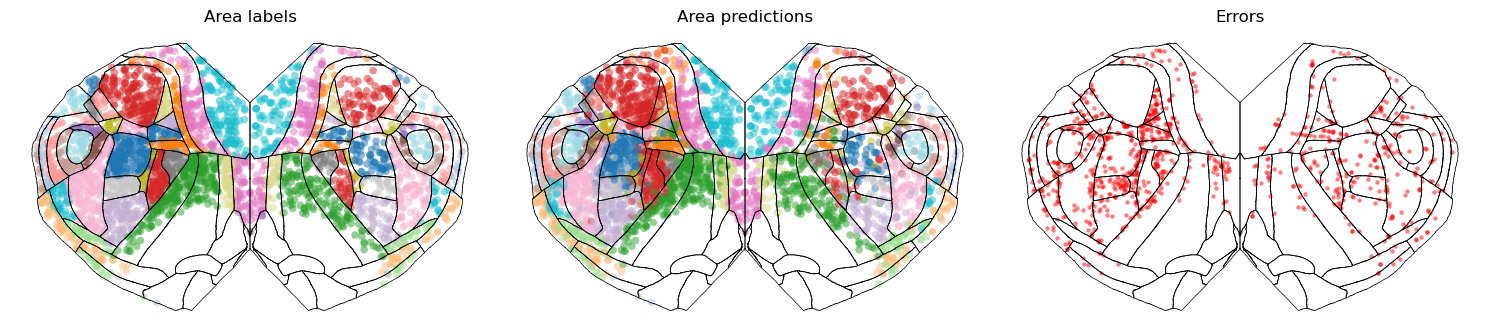

In [65]:
n=1000000
every = 1

categories = np.unique(pred_dict['labels'])
cs = np.random.permutation(np.array(sns.color_palette("tab20", len(categories))))

f, ax = plt.subplots(1, 3, figsize=(15, 5))

### Panel 1
color_idx = [categories.tolist().index(j) for j in pred_dict['labels'][:n:every]]
ax[0].scatter(np.array(pred_dict['locations'])[:n:every,0], np.array(pred_dict['locations'])[:n:every,1], color=cs[color_idx], 
            alpha=.5, linewidths=0, s=30)
ax[0].set_title("Area labels")

### Panel 2
color_idx = [categories.tolist().index(j) for j in pred_dict['predictions'][:n:every]]
ax[1].scatter(np.array(pred_dict['locations'])[:n:every,0], np.array(pred_dict['locations'])[:n:every,1], color=cs[color_idx], 
            alpha=.5, linewidths=0, s=30)
ax[1].set_title("Area predictions")

### Panel 3
misclassified = np.array(pred_dict['labels']) != np.array(pred_dict["predictions"])
x = np.array(pred_dict['locations'])[misclassified][:n:every,0]
y = np.array(pred_dict['locations'])[misclassified][:n:every,1]

ax[2].scatter(x,y, color='r',  alpha=.5, linewidths=0, s=10)
ax[2].set_title("Errors")

for a in ax:
    a.grid(False)
    for k, boundary_coords in bf_left_boundaries_flat.items():
        a.plot(*boundary_coords.T, c="k", lw=0.5)
    for k, boundary_coords in bf_right_boundaries_flat.items():
        a.plot(*boundary_coords.T, c="k", lw=0.5)

    a.axis('off')
    a.set_aspect('equal')
plt.tight_layout()
plt.savefig('single_cell_preds_32_val.png', dpi=300)
plt.show()


## Class weights model

Accuracy 72.84900284900286


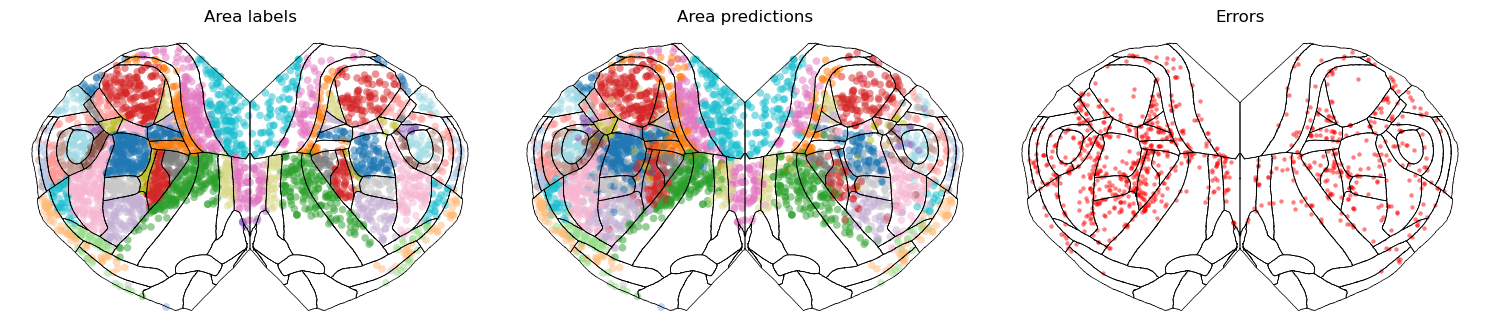

In [66]:

predictions_path = "/grid/zador/home/benjami/brain-annotation/outputs/class_weights_32/validation_brain_predictions.npy"
pred_dict = np.load(predictions_path, allow_pickle=True).item()

acc = (np.array(pred_dict['labels']) == np.array(pred_dict["predictions"])).sum() / len(pred_dict['labels'])
print("Accuracy", 100*acc)

n=1000000
every = 1
f, ax = plt.subplots(1, 3, figsize=(15, 5))

### Panel 1
color_idx = [categories.tolist().index(j) for j in pred_dict['labels'][:n:every]]
ax[0].scatter(np.array(pred_dict['locations'])[:n:every,0], np.array(pred_dict['locations'])[:n:every,1], color=cs[color_idx], 
            alpha=.5, linewidths=0, s=30)
ax[0].set_title("Area labels")

### Panel 2
color_idx = [categories.tolist().index(j) for j in pred_dict['predictions'][:n:every]]
ax[1].scatter(np.array(pred_dict['locations'])[:n:every,0], np.array(pred_dict['locations'])[:n:every,1], color=cs[color_idx], 
            alpha=.5, linewidths=0, s=30)
ax[1].set_title("Area predictions")

### Panel 3
misclassified = np.array(pred_dict['labels']) != np.array(pred_dict["predictions"])
x = np.array(pred_dict['locations'])[misclassified][:n:every,0]
y = np.array(pred_dict['locations'])[misclassified][:n:every,1]

ax[2].scatter(x,y, color='r',  alpha=.5, linewidths=0, s=10)
ax[2].set_title("Errors")

for a in ax:
    a.grid(False)
    for k, boundary_coords in bf_left_boundaries_flat.items():
        a.plot(*boundary_coords.T, c="k", lw=0.5)
    for k, boundary_coords in bf_right_boundaries_flat.items():
        a.plot(*boundary_coords.T, c="k", lw=0.5)

    a.axis('off')
    a.set_aspect('equal')
plt.tight_layout()
plt.savefig('class_weights_32_val.png', dpi=300)
plt.show()




## Single cells

In [67]:
# /grid/zador/home/benjami/brain-annotation/outputs/2024-11-18/15-22-43
predictions_path = "/grid/zador/home/benjami/brain-annotation/outputs/class_weights_ss_256/validation_brain_predictions.npy" # 256 cells
pred_dict = np.load(predictions_path, allow_pickle=True).item()

dataset = load_from_disk("/grid/zador/data_norepl/Ari/transcriptomics/barseq/Chen2023/train_test_barseq.dataset")




Accuracy 75.10612871004567


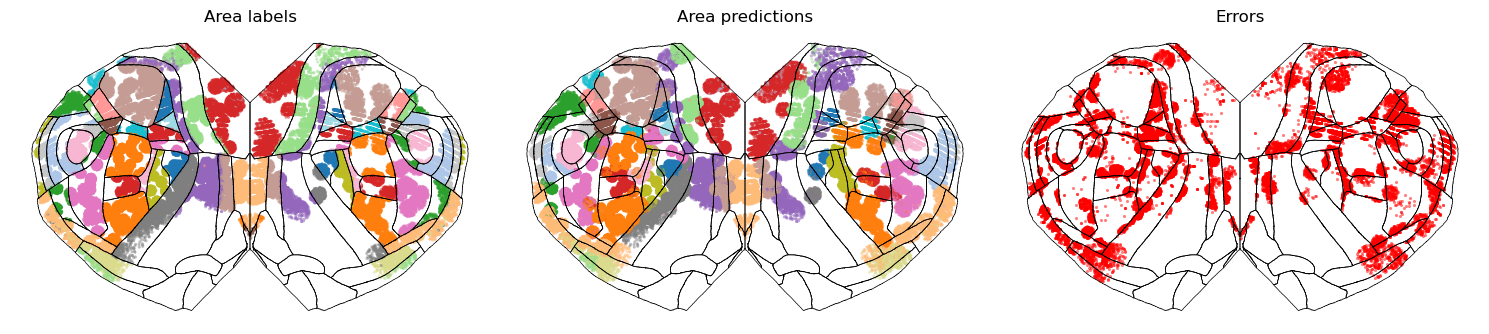

In [77]:
every = 1

labels = np.array(pred_dict['single_cell_labels']).flatten()[::every]
preds = np.array(pred_dict['single_cell_predictions']).flatten()[::every]
indices = np.array(pred_dict['indices']).flatten()[::every]

xyz = np.array(dataset['train'][indices]['CCF_streamlines'])
x = xyz[:,0]
y = xyz[:,1]

acc = (preds == labels).sum() / len(labels)
print("Accuracy", 100*acc)

categories = list(set(np.unique(preds)) | set(np.unique(labels)))
cs = np.random.permutation(np.array(sns.color_palette("tab20", len(categories))))

f, ax = plt.subplots(1, 3, figsize=(15, 5))

### Panel 1
color_idx = [categories.index(j) for j in labels]
ax[0].scatter(x,y, color=cs[color_idx], 
            alpha=.5, linewidths=0, s=5)
ax[0].set_title("Area labels")

### Panel 2
color_idx = [categories.index(j) for j in preds]
ax[1].scatter(x,y, color=cs[color_idx], 
            alpha=.5, linewidths=0, s=5)
ax[1].set_title("Area predictions")

### Panel 3
misclassified = labels != preds
ax[2].scatter(x[misclassified],y[misclassified], color='r',  alpha=.5, linewidths=0, s=5)
ax[2].set_title("Errors")

for a in ax:
    a.grid(False)
    for k, boundary_coords in bf_left_boundaries_flat.items():
        a.plot(*boundary_coords.T, c="k", lw=0.5)
    for k, boundary_coords in bf_right_boundaries_flat.items():
        a.plot(*boundary_coords.T, c="k", lw=0.5)

    a.axis('off')
    a.set_aspect('equal')
plt.tight_layout()
plt.savefig('cellular_class_weights_256_val.png', dpi=300)
plt.show()


Hex dataloading strategy

In [4]:
group_size = 32
val_or_test = "validation"

predictions_path = f"/grid/zador/home/benjami/brain-annotation/outputs/single_cell_preds_hex_groups_fix_v4_{group_size}/{val_or_test}_brain_predictions.npy" # group_size cells
pred_dict = np.load(predictions_path, allow_pickle=True).item()
dataset = load_from_disk("/grid/zador/data_norepl/Ari/transcriptomics/barseq/Chen2023/train_test_barseq.dataset")

def reflect_points_to_left(coords: np.ndarray) -> np.ndarray:

    x_line = 1176.5
    reflected = coords.copy()
    
    # Only reflect points where x > x_line
    right_side_mask = coords[:, 0] > x_line
    reflected[right_side_mask, 0] = 2 * x_line - coords[right_side_mask, 0]
    
    return reflected 

#### Examine that seeds are OK

Accuracy 89.5940170940171


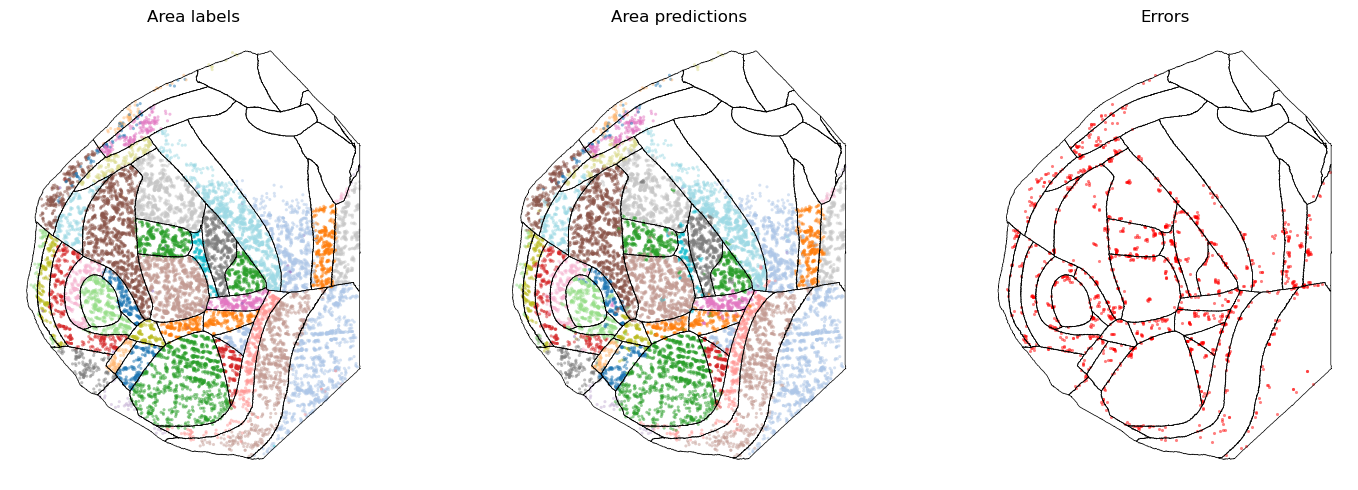

Accuracy 89.5940170940171


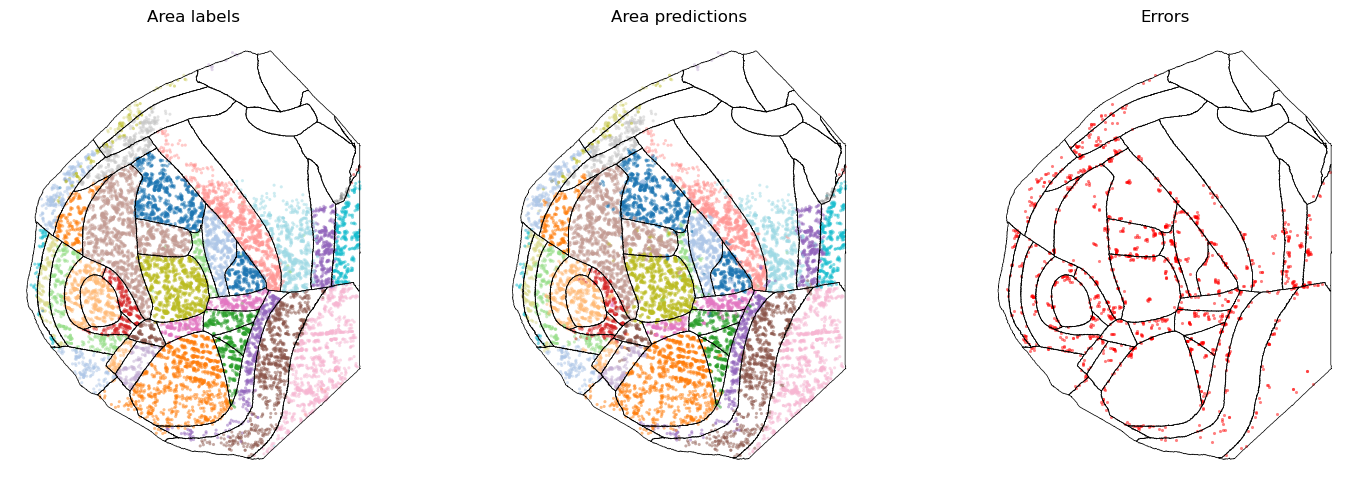

Accuracy 89.5940170940171


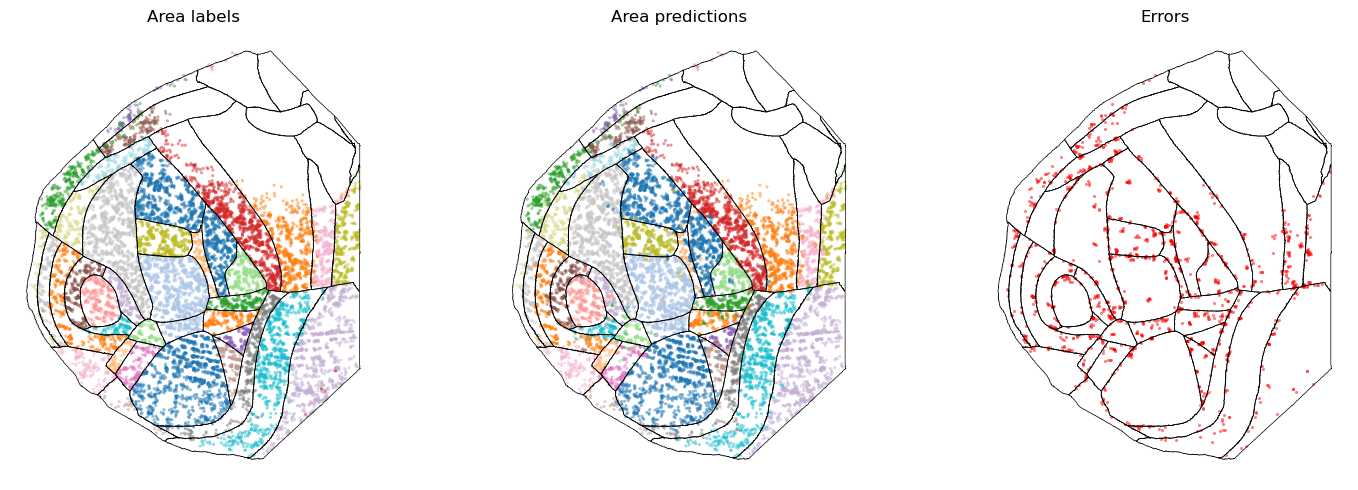

Accuracy 89.5940170940171


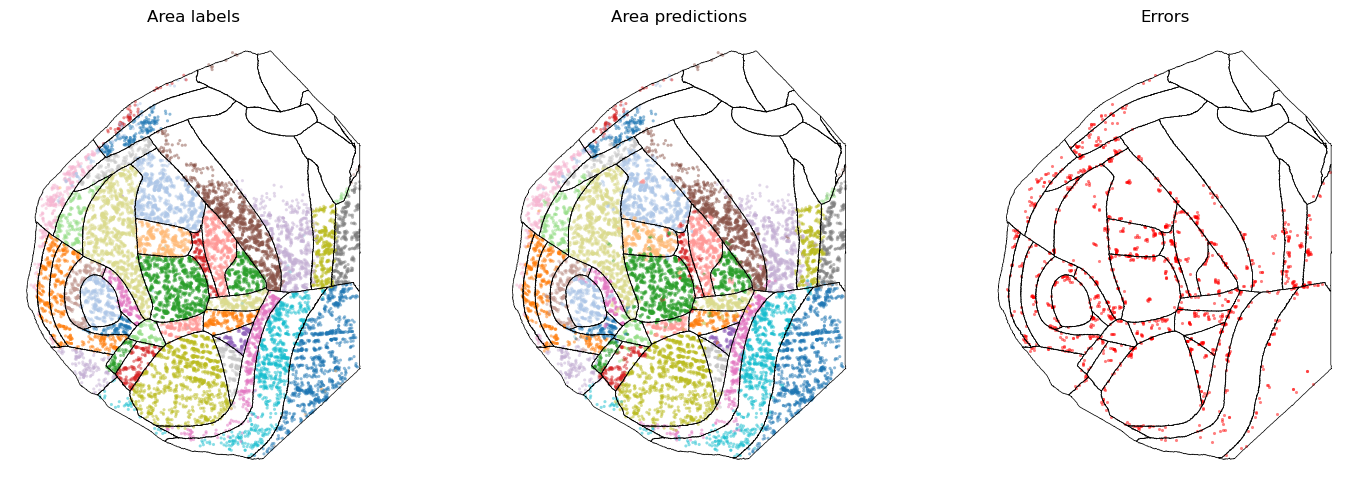

Accuracy 89.5940170940171


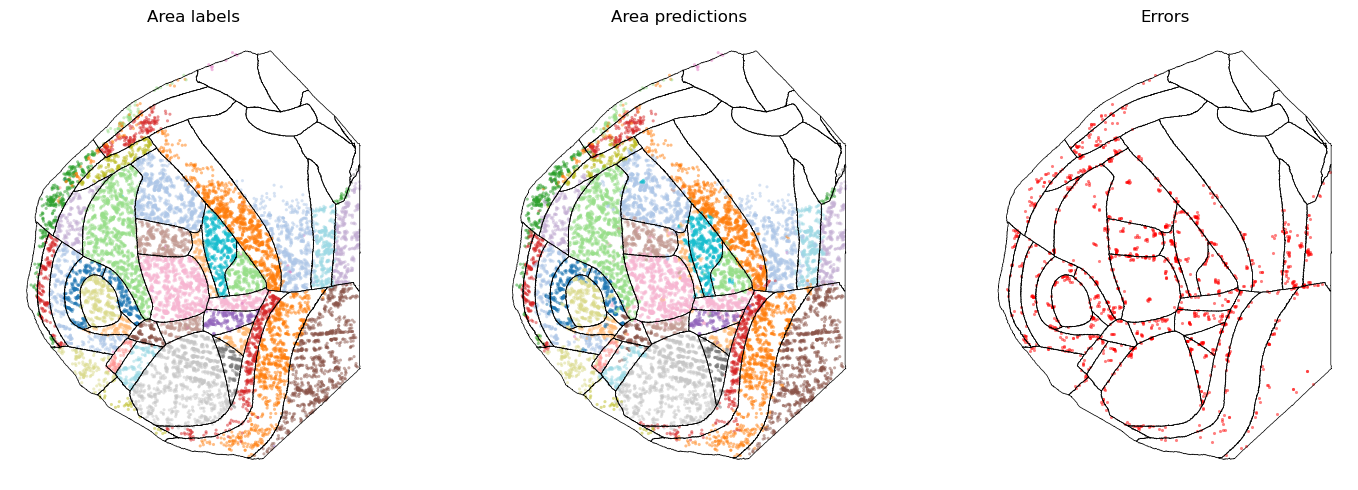

Accuracy 89.5940170940171


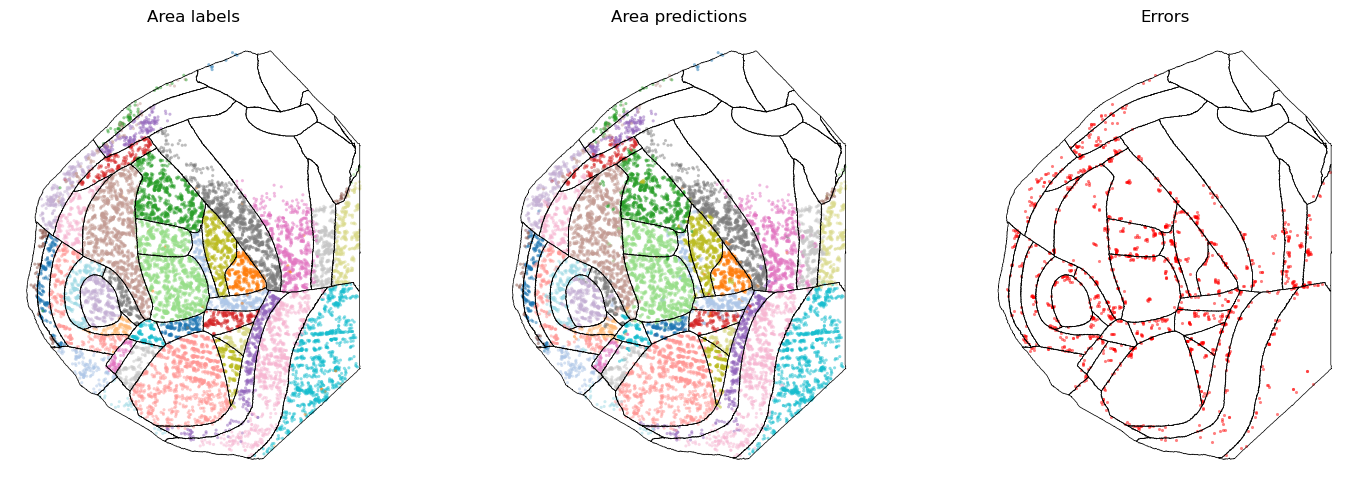

Accuracy 89.5940170940171


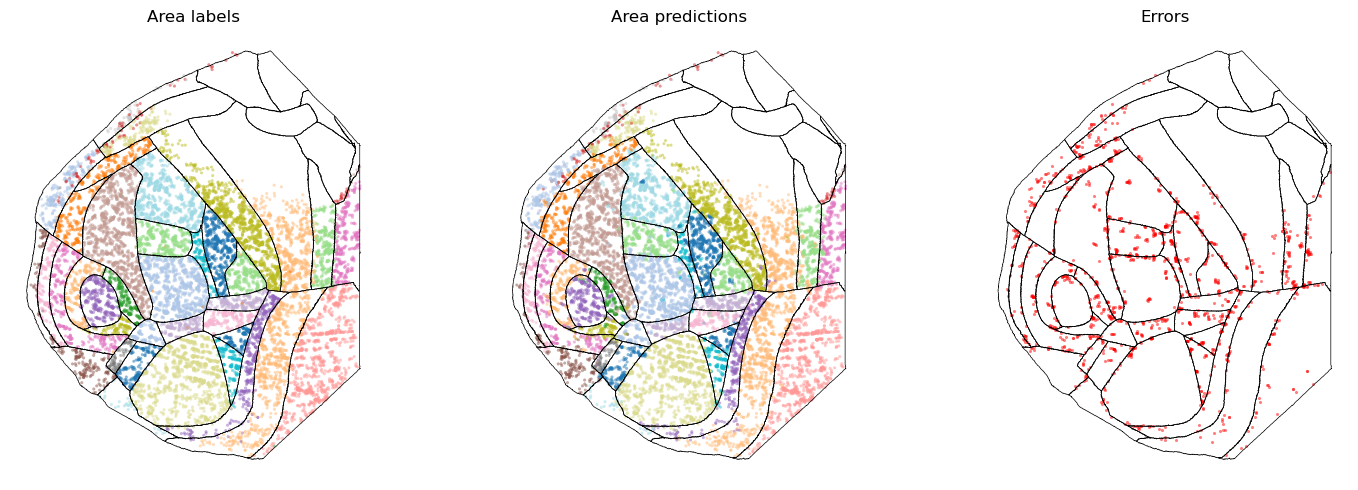

Accuracy 89.5940170940171


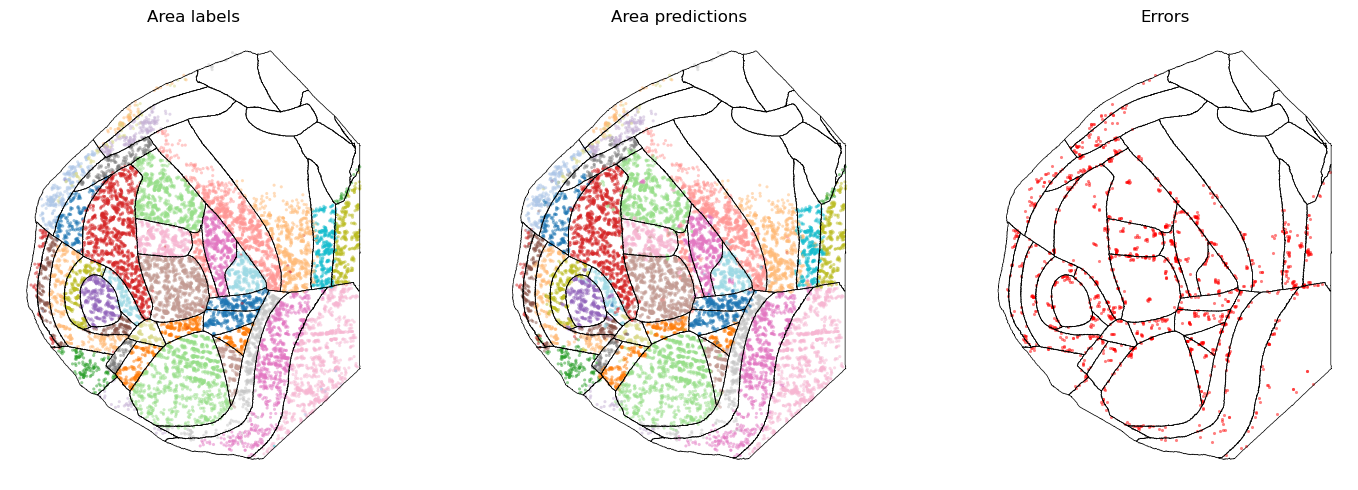

Accuracy 89.5940170940171


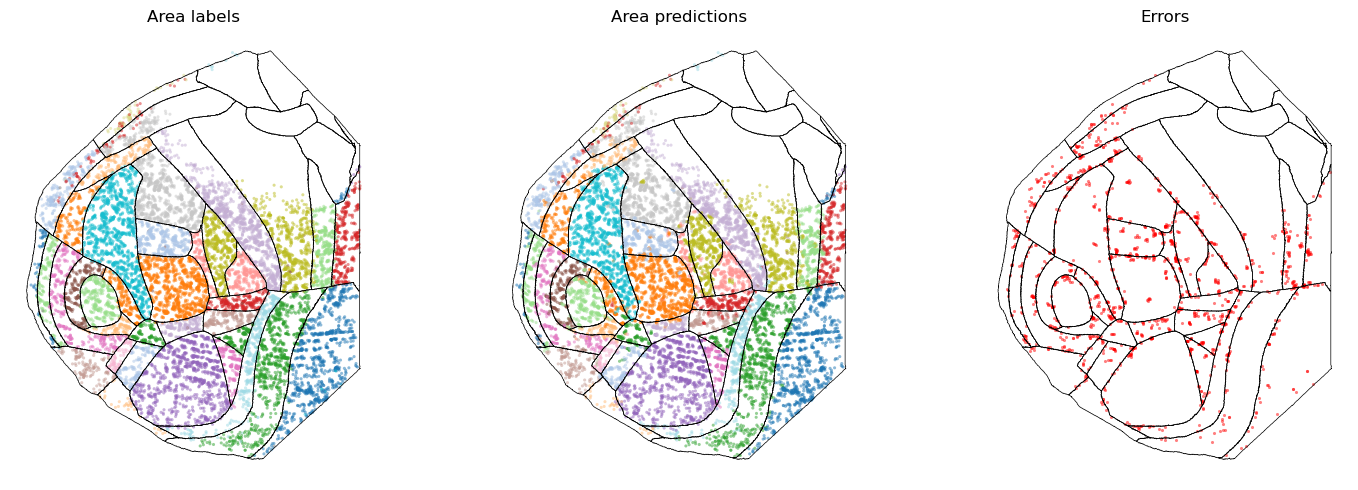

Accuracy 89.5940170940171


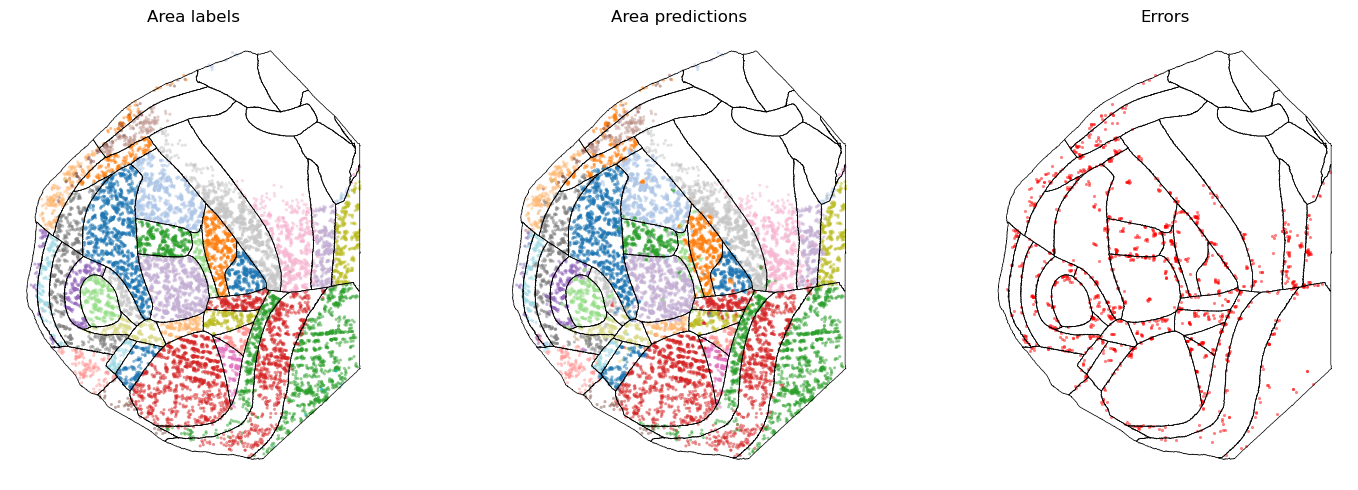

In [74]:

every = 8


labels = np.array(pred_dict['single_cell_labels'])
preds = np.array(pred_dict['single_cell_predictions']).reshape(*labels.shape)
indices = np.array(pred_dict['indices'])

num_cells = len(preds)
cells_per_epoch = num_cells//10

for i in range(10):
    start_idx = i * cells_per_epoch
    end_idx = (i + 1) * cells_per_epoch
    labels_epoch = labels[start_idx:end_idx].flatten()[::every]
    preds_epoch = preds[start_idx:end_idx].flatten()[::every]
    indices_epoch = indices[start_idx:end_idx].flatten()[::every]

    xyz = np.array(dataset['train'][indices_epoch]['CCF_streamlines']) if (val_or_test == "validation") else np.array(dataset['test'][indices_epoch]['CCF_streamlines'])
    xyz = reflect_points_to_left(xyz)
    x = xyz[:,0]
    y = xyz[:,1]

    acc = (preds_epoch == labels_epoch).sum() / len(labels_epoch)
    print("Accuracy", 100*acc)

    categories = list(set(np.unique(preds_epoch)) | set(np.unique(labels_epoch)))
    cs = np.random.permutation(np.array(sns.color_palette("tab20", len(categories))))

    f, ax = plt.subplots(1, 3, figsize=(15, 5))

    ### Panel 1
    color_idx = [categories.index(j) for j in labels_epoch]
    ax[0].scatter(x,y, color=cs[color_idx], 
                alpha=.5, linewidths=0, s=5)
    ax[0].set_title("Area labels")

    ### Panel 2
    color_idx = [categories.index(j) for j in preds_epoch]
    ax[1].scatter(x,y, color=cs[color_idx], 
                alpha=.5, linewidths=0, s=5)
    ax[1].set_title("Area predictions")

    ### Panel 3
    misclassified = labels_epoch != preds_epoch
    ax[2].scatter(x[misclassified],y[misclassified], color='r',  alpha=.5, linewidths=0, s=5)
    ax[2].set_title("Errors")

    for a in ax:
        a.grid(False)
        for k, boundary_coords in bf_left_boundaries_flat.items():
            a.plot(*boundary_coords.T, c="k", lw=0.5)

        a.axis('off')
        a.set_aspect('equal')
        # reverse y-axis
        a.set_ylim(a.get_ylim()[::-1])
    plt.tight_layout()
    plt.show()


### Preds

Accuracy 76.51264245014245


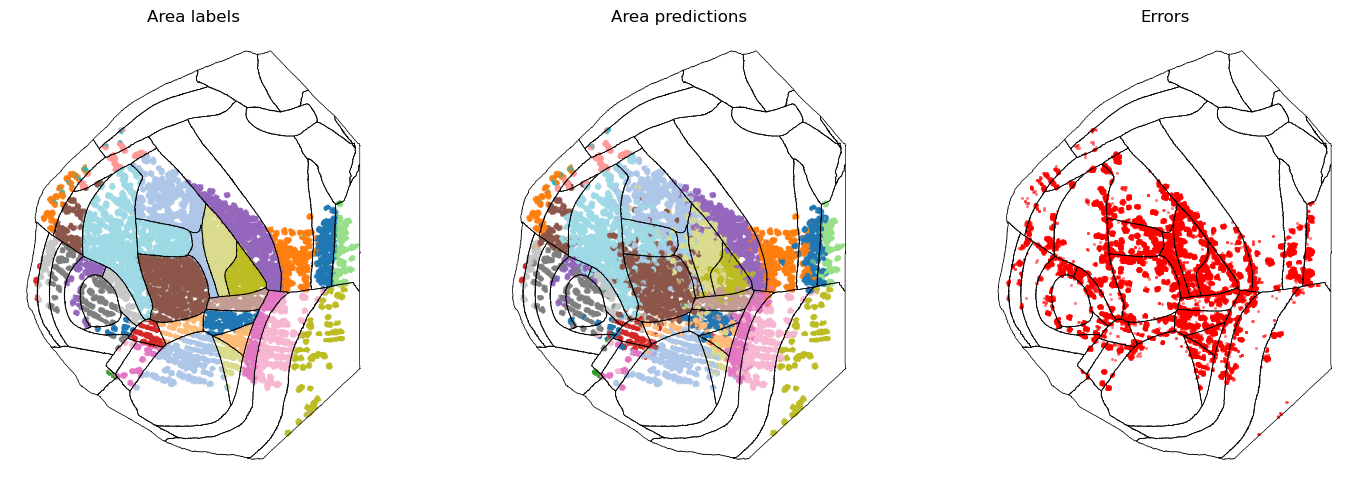

In [5]:

every = 1

labels = np.array(pred_dict['single_cell_labels']).flatten()[::every]
preds = np.array(pred_dict['single_cell_predictions']).flatten()[::every]
indices = np.array(pred_dict['indices']).flatten()[::every]


xyz = np.array(dataset['train'][indices]['CCF_streamlines']) if (val_or_test == "validation") else np.array(dataset['test'][indices]['CCF_streamlines'])
xyz = reflect_points_to_left(xyz)
x = xyz[:,0]
y = xyz[:,1]

acc = (preds == labels).sum() / len(labels)
print("Accuracy", 100*acc)

categories = list(set(np.unique(preds)) | set(np.unique(labels)))
cs = np.random.permutation(np.array(sns.color_palette("tab20", len(categories))))

f, ax = plt.subplots(1, 3, figsize=(15, 5))

### Panel 1
color_idx = [categories.index(j) for j in labels]
ax[0].scatter(x,y, color=cs[color_idx], 
            alpha=.5, linewidths=0, s=5)
ax[0].set_title("Area labels")

### Panel 2
color_idx = [categories.index(j) for j in preds]
ax[1].scatter(x,y, color=cs[color_idx], 
            alpha=.5, linewidths=0, s=5)
ax[1].set_title("Area predictions")

### Panel 3
misclassified = labels != preds
ax[2].scatter(x[misclassified],y[misclassified], color='r',  alpha=.5, linewidths=0, s=5)
ax[2].set_title("Errors")

for a in ax:
    a.grid(False)
    for k, boundary_coords in bf_left_boundaries_flat.items():
        a.plot(*boundary_coords.T, c="k", lw=0.5)

    a.axis('off')
    a.set_aspect('equal')
    # reverse y-axis
    a.set_ylim(a.get_ylim()[::-1])
plt.tight_layout()
plt.savefig(f'single-cell-preds-hex-{val_or_test}-{group_size}.png', dpi=300)
plt.show()


/tmp/ipykernel_3005661/3253578021.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])


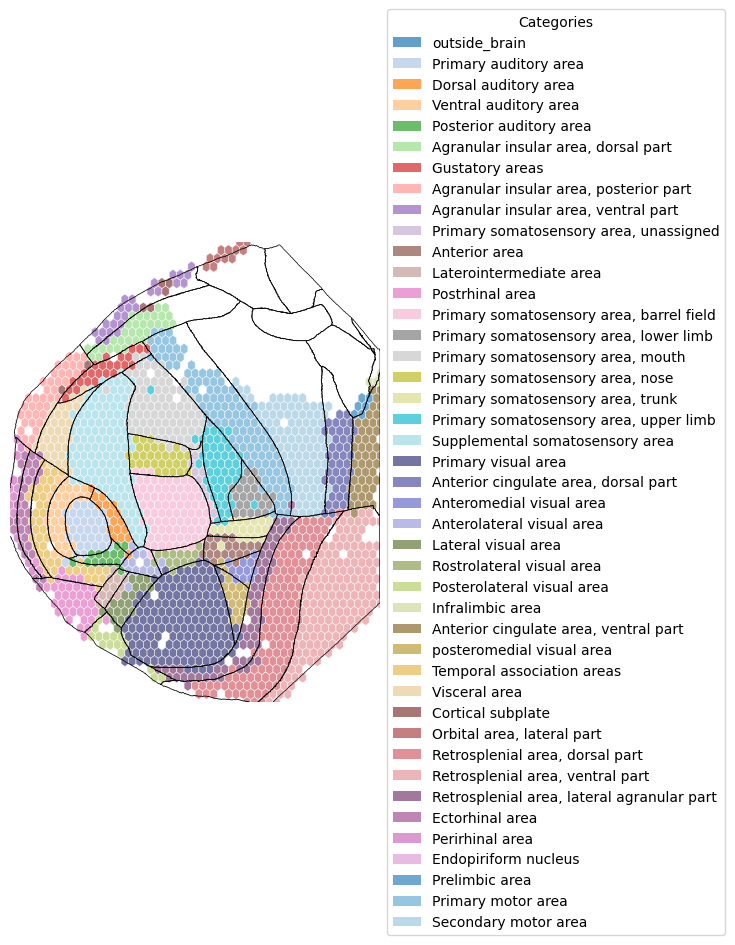

In [75]:
import matplotlib as mpl

def create_hexbin_categorical(x, y, labels, label_map=None, gridsize=30):
    """
    Create a hexagonal binning plot for categorical data.
    
    Parameters:
    -----------
    x : array-like
        x-coordinates of the points
    y : array-like
        y-coordinates of the points
    labels : array-like
        categorical labels for each point
    label_map : dict, optional
        mapping from numerical IDs to string labels for legend
    gridsize : int, optional
        number of hexagons in the x-direction
    
    Returns:
    --------
    fig : matplotlib figure
    ax : matplotlib axes
    hexbin_data : pandas DataFrame
    """
    # Convert data to DataFrame
    df = pd.DataFrame({
        'x': x,
        'y': y,
        'label': labels
    })
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Calculate data extent
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    
    # Create a temporary hexbin to get the hex locations and sizes
    hb = ax.hexbin(x, y, gridsize=gridsize, extent=(xmin, xmax, ymin, ymax), visible=False)
    
    # Get hex centers and corners
    hex_centers = hb.get_offsets()
    hex_path = hb.get_paths()[0]
    
    # Function to find modal category
    def get_modal_category(points):
        if len(points) == 0:
            return np.nan
        values, counts = np.unique(points, return_counts=True)
        if len(counts) == 0:
            return np.nan
        return values[np.argmax(counts)]
    
    hex_stats = []
    for i, center in enumerate(hex_centers):
        # Transform the generic hex path to this specific hexagon's position
        vertices = hex_path.vertices + center
        
        # Find points within this hexagon
        mask = mpl.path.Path(vertices).contains_points(df[['x', 'y']])
        if mask.any():
            points_in_hex = df[mask]
            modal_cat = get_modal_category(points_in_hex['label'])
            hex_stats.append({
                'hex_id': i,
                'modal_category': modal_cat,
                'count': len(points_in_hex),
                'center_x': center[0],
                'center_y': center[1]
            })
    
    hex_stats = pd.DataFrame(hex_stats)
    
    # Create extended colormap by combining multiple colorschemes
    colormaps = ['tab20', 'tab20b', 'tab20c']
    colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])

    # Get unique categories and map to extended colors
    unique_categories = np.unique(labels[~pd.isna(labels)])
    n_categories = len(unique_categories)
    color_indices = np.arange(n_categories) % len(colors)
    category_colors = dict(zip(unique_categories, colors[color_indices]))
    
    # Create collection of hexagons
    patches = []
    colors = []
    for _, row in hex_stats.iterrows():
        center = (row['center_x'], row['center_y'])
        vertices = hex_path.vertices + center
        patch = mpl.patches.Polygon(vertices)
        patches.append(patch)
        colors.append(category_colors[row['modal_category']])
    
    # Plot hexagons
    collection = mpl.collections.PatchCollection(
        patches, 
        facecolors=colors,
        edgecolors='white',
        linewidth=0.5,
        alpha=0.7
    )
    ax.add_collection(collection)
    
    # Set plot limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # Add legend with mapped labels
    legend_elements = [plt.Rectangle((0, 0), 1, 1, facecolor=color, alpha=0.7)
                      for color in category_colors.values()]
    
    if label_map is not None:
        legend_labels = [label_map.get(int(cat), str(cat)) for cat in category_colors.keys()]
    else:
        legend_labels = [str(cat) for cat in category_colors.keys()]
    
    ax.legend(legend_elements, legend_labels,
             title='Categories', loc='center left', bbox_to_anchor=(1, 0.5))
        
    # Set equal aspect ratio
    ax.set_aspect('equal')

    ax.grid(False)
    for k, boundary_coords in bf_left_boundaries_flat.items():
        ax.plot(*boundary_coords.T, c="k", lw=0.5)

    ax.axis('off')
    # reverse y-axis
    ax.set_ylim(ax.get_ylim()[::-1])
    
    # Adjust layout to prevent legend overlap
    plt.tight_layout()


    
    return fig, ax, hex_stats

every = 1

labels = np.array(pred_dict['single_cell_labels']).flatten()[::every]
preds = np.array(pred_dict['single_cell_predictions']).flatten()[::every]
indices = np.array(pred_dict['indices']).flatten()[::every]

xyz = np.array(dataset['train'][indices]['CCF_streamlines']) if (val_or_test == "validation") else np.array(dataset['test'][indices]['CCF_streamlines'])
xyz = reflect_points_to_left(xyz)
x = xyz[:,0]
y = xyz[:,1]
fig, ax, hex_stats = create_hexbin_categorical(x, y, preds,{int(k): v for k, v in pred_dict['label_names'].items()}, gridsize=50)



##### Split group labels with group size



In [7]:

def check_identical_rows(arr):
    """
    Returns a boolean array indicating which rows have identical elements.
    
    Parameters:
    arr (numpy.ndarray): 2D input array
    
    Returns:
    numpy.ndarray: 1D boolean array, True where row elements are identical
    """
    return np.all(arr == arr[:, [0]], axis=1)

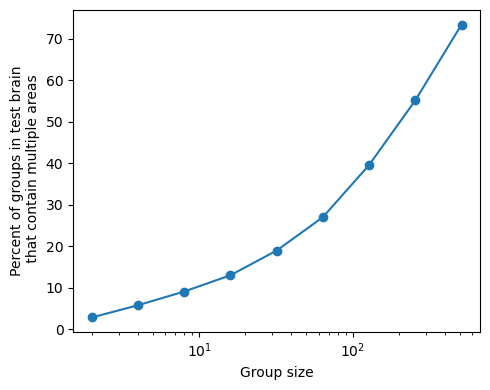

In [22]:
group_sizes = np.exp2(np.arange(1,10))
frac_single_labels = []

for group_size in group_sizes:
    predictions_path = f"/grid/zador/home/benjami/brain-annotation/outputs/single_cell_preds_hex_groups_{group_size:.0f}/test_brain_predictions.npy" # group_size cells
    pred_dict = np.load(predictions_path, allow_pickle=True).item()

    labels = np.array(pred_dict['single_cell_labels'])

    frac_single_labels.append((1-check_identical_rows(labels).sum() / len(labels))*100)
    
plt.figure(figsize=(5,4))
plt.plot(group_sizes, frac_single_labels, marker='o')

plt.xlabel("Group size")
plt.ylabel("Percent of groups in test brain\n that contain multiple areas")
plt.xscale('log', base=10)
plt.tight_layout()
plt.savefig("num_areas_in_group.png", dpi=300)



In [5]:
predictions_path = f"/grid/zador/home/benjami/brain-annotation/outputs/single_cell_preds_hex_groups_32/validation_brain_predictions.npy" # group_size cells
pred_dict = np.load(predictions_path, allow_pickle=True).item()
pred_dict['indices'].shape

torch.Size([3510, 32])